In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms

import utils

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'using {device}')

using cuda:0


In [2]:
# load in data and scale to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

data_folder = 'data'
trainset = torchvision.datasets.MNIST(root=data_folder, train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root=data_folder, train=False, download=True, transform=transform);

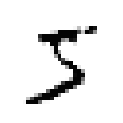

In [3]:
utils.plot_images(trainset[0][0], figsize=(2,2))

In [4]:
# build the generator

class Generator(nn.Module):
    def __init__(self, nz=10, ngf=64, nc=1):
        """
        Args:
          nz: Number of elements in the sampled z vector
          ngf: Base size (number of channels) in the generator layers
          nc: Number of channels in the generated images
        """
        super().__init__()
        self.nz = nz
        self.ngf = ngf
        self.nc = nc
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(nz, 4*ngf, 4, bias=False, stride=2, padding=0),
            nn.BatchNorm2d(4*ngf),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(4*ngf, 2*ngf, 4, bias=False, stride=2, padding=1),
            nn.BatchNorm2d(2*ngf),
            nn.ReLU(),
        )
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(2*ngf, ngf, 4, bias=False, stride=2, padding=1),
            nn.BatchNorm2d(ngf),
            nn.ReLU(),
        )
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, bias=False, stride=2, padding=3),
            nn.Tanh(),
        )
        
    def forward(self, z, verbose=False):
        """Generate images by transforming the given noise vector z
        
        Args:
            z of shape (batch_size, nz, 1, 1)
            
        Returns:
            output of shape (batch_size, nc, 28, 28)
        """
        out1 = self.layer1(z)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)
        
        if verbose:
            print(f"Layer1 shape: {out1.shape}")
            print(f"Layer2 shape: {out2.shape}")
            print(f"Layer3 shape: {out3.shape}")
            print(f"Layer4 shape: {out4.shape}")

        return out4

In [5]:
# print out shapes
nz = 10
netG = Generator(nz, ngf=64, nc=1)

batch_size = 32
noise = torch.randn(batch_size, nz, 1, 1)
out = netG(noise, verbose=True)

Layer1 shape: torch.Size([32, 256, 4, 4])
Layer2 shape: torch.Size([32, 128, 8, 8])
Layer3 shape: torch.Size([32, 64, 16, 16])
Layer4 shape: torch.Size([32, 1, 28, 28])


In [6]:
# specify what the loss will be for the generator
REAL_LABEL = 1.
FAKE_LABEL = 0.

def generator_loss(netD, fake_images):
    """Fake images of shape (batch_size, nc, 28, 28) fed to a discriminator"""
    d_output = netD(fake_images)
    target_vector = torch.full((d_output.shape), REAL_LABEL, device=fake_images.device)
    
    loss = F.binary_cross_entropy(d_output, target_vector, reduction='mean')
    return loss

In [7]:
# build the discriminator
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=64):
        super().__init__()
        self.nc = nc
        self.ndf = ndf
        self.layer1 = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(ndf, 2*ndf, 4, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(2*ndf),
            nn.LeakyReLU(0.2),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(2*ndf, 4*ndf, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(4*ndf),
            nn.LeakyReLU(0.2),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(4*ndf, 1, 4, stride=2, bias=False),
            nn.Sigmoid(),
            nn.Flatten(start_dim=0)
        )
        
    def forward(self, x, verbose=False):
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)
        
        if verbose:
            print(f"Layer1 shape: {out1.shape}")
            print(f"Layer2 shape: {out2.shape}")
            print(f"Layer3 shape: {out3.shape}")
            print(f"Layer4 shape: {out4.shape}")
        
        return out4

In [8]:
# print out shapes of discriminator
netD = Discriminator()
x = torch.ones(12, 1, 28, 28)
out = netD(x, verbose=True)

Layer1 shape: torch.Size([12, 64, 14, 14])
Layer2 shape: torch.Size([12, 128, 8, 8])
Layer3 shape: torch.Size([12, 256, 4, 4])
Layer4 shape: torch.Size([12])


In [9]:
# loss for the discriminator
def discriminator_loss(netD, real_images, fake_images):
    device = fake_images.device
    d_real_out = netD(real_images)
    d_fake_out = netD(fake_images)
    
    # take means of loss for measurement
    D_real = torch.mean(d_real_out)
    D_fake = torch.mean(d_fake_out)
    
    real_targets = torch.full((d_real_out.shape), REAL_LABEL, device=device)
    fake_targets = torch.full((d_fake_out.shape), FAKE_LABEL, device=device)
    
    d_loss_real = F.binary_cross_entropy(d_real_out, real_targets, reduction='mean')
    d_loss_fake = F.binary_cross_entropy(d_fake_out, fake_targets, reduction='mean')
    
    return d_loss_real, D_real, d_loss_fake, D_fake

In [44]:
# adding the conditional information
def one_hot_encode(labels, num_classes=10):
    """given labels of shape (labels) 
    return OHE representation of shape (labels, num_classes, 1, 1)
    """
    return F.one_hot(labels, num_classes).unsqueeze(-1).unsqueeze(-1)

def combine(x, y):
    """For adding class labels to random data"""
    return torch.cat([x, y.float()], dim=1)



In [45]:
# Training
num_classes = 10  # 10 digits
nz = 10
netG = Generator(nz=nz + num_classes, ngf=64, nc=1)
netD = Discriminator(nc=1 + num_classes, ndf=64)

netD = netD.to(device)
netG = netG.to(device)

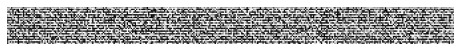

In [46]:
# print output before model is trained at all
z = torch.randn(12, nz + num_classes, 1, 1, device=device)
fake = netG(z)
utils.plot_generated_samples(fake)


In [47]:
#samples_for_plot = [fake]

Epoch [1/20] iter [118/118]: D_real=0.740, D_fake=0.703


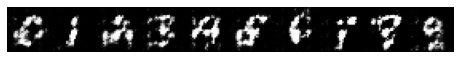

Epoch [3/20] iter [118/118]: D_real=0.807, D_fake=0.687


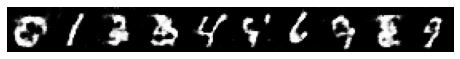

Epoch [5/20] iter [118/118]: D_real=0.560, D_fake=0.505


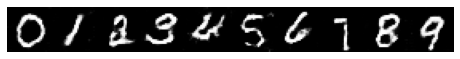

Epoch [7/20] iter [118/118]: D_real=0.326, D_fake=0.300


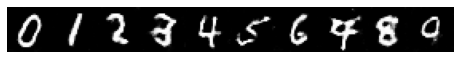

Epoch [9/20] iter [118/118]: D_real=0.660, D_fake=0.606


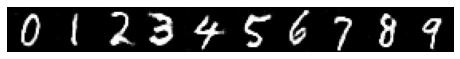

Epoch [11/20] iter [118/118]: D_real=0.489, D_fake=0.468


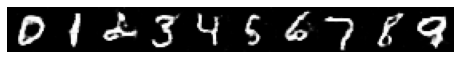

Epoch [13/20] iter [118/118]: D_real=0.556, D_fake=0.504


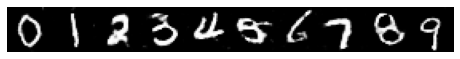

Epoch [15/20] iter [118/118]: D_real=0.628, D_fake=0.612


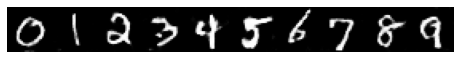

Epoch [17/20] iter [118/118]: D_real=0.490, D_fake=0.457


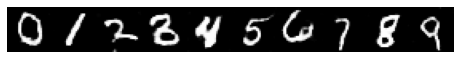

Epoch [19/20] iter [118/118]: D_real=0.474, D_fake=0.459


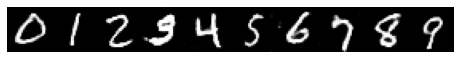

Finished


In [51]:
# create the training loop
def eval(generator):
    with torch.no_grad():
        labels = torch.LongTensor([0,1,2,3,4,5,6,7,8,9]).to(device)
        ohe = one_hot_encode(labels)
        z = torch.randn(10, nz, 1, 1, device=device)
        comb = combine(z, ohe)
        samples = generator(comb)
        #samples_for_plot.append(samples)
    utils.plot_generated_samples(samples, ncol=10)

bsize = 512
dataloader = torch.utils.data.DataLoader(trainset, batch_size=bsize, shuffle=True, num_workers=4)
d_optimizer = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
epochs = 20

D_reals, D_fakes = [], []

for e in range(epochs):
    netG.train()
    netD.train()
    for i, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        current_bsize = len(labels)
        
        # encoding
        encoded_labels = one_hot_encode(labels)
        z = torch.randn(current_bsize, nz, 1, 1, device=device)
        # combine label information with the generated random vector
        # along the second dimension
        z_labels = combine(z, encoded_labels)
        
        # to add label information to the discriminator, need to be able to
        # do it in image size, so 28x28
        enc_disc = encoded_labels.clone().repeat(1, 1, 28, 28)
        
        # generate images
        fake_images = netG(z_labels)
        
        # and add label info to both real and fake images
        labelled_real = combine(images, enc_disc)
        labelled_fake = combine(fake_images.detach(), enc_disc)
        
        # loss of discriminator
        d_optimizer.zero_grad()
        d_loss_real, D_real, d_loss_fake, D_fake = discriminator_loss(netD, labelled_real, labelled_fake)
        d_loss_real.backward(retain_graph=True)
        d_loss_fake.backward(retain_graph=True)
        d_optimizer.step()
        
        # loss of generator
        g_optimizer.zero_grad()
        z_ = torch.randn(current_bsize, nz, 1, 1, device=device)
        new_images = netG(combine(z_, encoded_labels))
        labelled_new_images = combine(new_images, enc_disc)
        g_loss = generator_loss(netD, labelled_new_images)
        g_loss.backward()
        g_optimizer.step()
        
        D_reals.append(D_real.item())
        D_fakes.append(D_fake.item())
    
    if e % 2 == 0:
        print(f"Epoch [{e+1}/{epochs}] iter [{i+1}/{len(dataloader)}]: ", end='')
        print(f"D_real={D_real:.3f}, D_fake={D_fake:.3f}")
        eval(netG)
print("Finished")

In [99]:
import IPython
def plot_generated_samples(samples, ncol=12, savename=None):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.axis('off')
    d = np.transpose(
            torchvision.utils.make_grid(samples, nrow=ncol, padding=0, normalize=True).cpu(),
            (1,2,0)
        )
    ax.imshow(d)
    if savename:
        plt.imsave(f'images/{savename}', d.numpy())
    IPython.display.display(fig)
    plt.close(fig)

AttributeError: 'function' object has no attribute 'display'

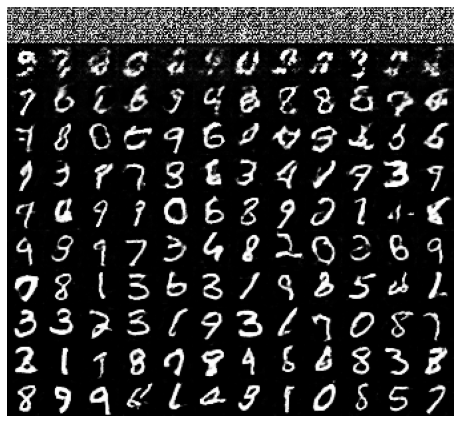

In [55]:
plot_generated_samples(torch.cat(samples_for_plot), savename='training-images.jpg')

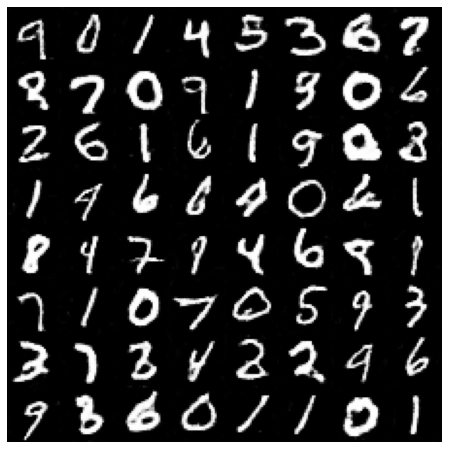

In [203]:
with torch.no_grad():
    z = torch.randn(8*8, nz, 1, 1, device=device)
    samples = netG(z)
plot_generated_samples(samples, ncol=8)

AttributeError: 'function' object has no attribute 'display'

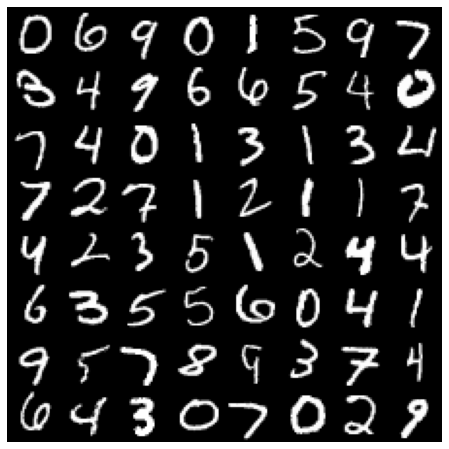

In [66]:
# plot and save real images
with torch.no_grad():
    a = [torch.unsqueeze(testset[i][0].to(device), dim=0) for i in range(10,10+(8*8))]
    a = torch.cat(a)
    plot_generated_samples(a, ncol=8, savename='real.jpg')

In [57]:
def save_model(model, filename):
    torch.save(model.state_dict(), filename)
    print(f'Model saved to {filename}')
    
def load_model(model, filename, device):
    model.load_state_dict(torch.load(filename, map_location=lambda storage, loc: storage))
    print(f'Model loaded from {filename}')
    model.to(device)
    model.eval()

In [58]:
g_file = 'models/generator'
d_file = 'models/discriminator'
save_model(netG, g_file)
save_model(netD, d_file)

Model saved to models/generator
Model saved to models/discriminator


Model loaded from models/generator


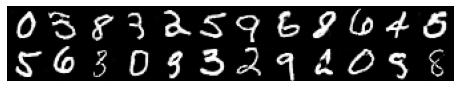

In [49]:
# trying testing
test_g = Generator(nz=nz, ngf=64, nc=1)
test_g.to(device)
load_model(test_g, g_file, device)

with torch.no_grad():
    z = torch.randn(24, nz, 1, 1, device=device)
    samples = test_g(z)
utils.plot_generated_samples(samples)

torch.Size([5, 1, 28, 28])


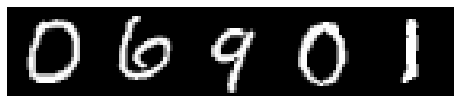

tensor([0.5190, 0.8076, 0.8521, 0.4617, 0.2787], device='cuda:0')


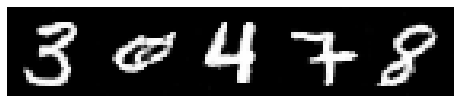

tensor([0.3853, 0.1258, 0.7190, 0.5826, 0.3920], device='cuda:0')


In [41]:
with torch.no_grad():
    a = [torch.unsqueeze(testset[i][0].to(device), dim=0) for i in range(10,10+5)]
    a = torch.cat(a)
    print(a.shape)
    utils.plot_generated_samples(a)
    print(netD(a))

    b = netG(torch.randn(5, nz, 1, 1, device=device))
    utils.plot_generated_samples(b)
    print(netD(b))

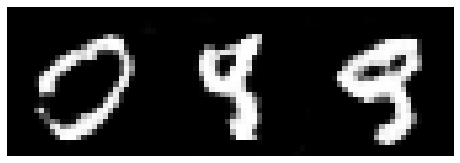

In [199]:
with torch.no_grad():
    z = torch.randn(1, nz, 1, 1, device=device)
    z_o = netG(z)
    x = torch.randn(1, nz, 1, 1, device=device)
    x_o = netG(x)
    zx = netG(z + x)
    
    plot_generated_samples(torch.cat([z_o, x_o, zx], dim=0), ncol=3)


In [171]:
print("hi")

hi
